# Algorithms Comparison thorugh Monte Carlo Analysis
In the first script, an analysis of the effect of the parasite terms (capacitance, $C_1$, and resistance, $R_0$) is performed using the Monte Carlo technique. This way, many simulations are performed to analyze the effect of the variations or uncertainties in the parasite terms over the theoretical estimation of viscosity through the step signal response. 

In this second script, the same approach is followed but with the aim of comparing the response of different algorithms to, first, the same parasite terms, and second, to different input signals.

The content of this notebook is the following:
- Assignation of values for all the elements of the circuits and their uncertainty ranges.
- Definition of all the equations involved in the analysis.
- Definition of estimation algorithms / load of estimation models.
- Monte Carlo analysis routine for parasite terms.
- Monte Carlo analysis routine for input signals.
- Results analysis.

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import pywt

from scipy import signal
from scipy.integrate import solve_ivp
from scipy.stats import norm as norm_dist

import pysindy as psdy

from nfoursid.nfoursid import NFourSID as nfsid

from sysidentpy.model_structure_selection import FROLS as sipFROLS
from sysidentpy.basis_function._basis_function import Polynomial as sipPoly

import tensorflow as tf

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 1. Elements of the circuit
The simulated circuit is showing here:

*Insert a diagram of the circuit*

Each dictionary holds the required values to define the associated element of the circuit. Within the dictionary there is a list called `"e_sources"`, or error sources. This list will contain all the parameters to be randomly modified in the Monte Carlo analysis. To do so, the parameter must have an associated parameter `_e`, which defined the absolute error associated to the parameter.

For example, if the diameter, `D`, of the first resistance, `R0`, must be analyzed, it must have an associated parameter `D_e`, defining the absolute uncertainty of that parameter. Also, `D` must be then included in the list `e_sources` of `R0`.

**Note**: It is important to respect the nomenclature in the dictionary of parameters. If it is a resistive element, it must start by `R`. If it is capacitive, `C`. After the identificative number, use a low bar, `_`, for the second part of the name (e.g. `R0_params`).

In [3]:
# Input resistance
elements = {
    "R0_params": {
        "D": 500e-6,
        "L": 125e-2, # 25e-2
        "e_sources": [],
        "e": {
            "D_e": 50e-6,
            "L_e": 1e-3
        }
    },

    # First RC Branch
    "R1_params": {
        "D": 150e-6,
        "L": 10e-2,
        "e_sources": [],
        "e": {
            "D_e": 15e-6,
            "L_e": 1e-3
        }
    },
    "C1_params": {
        "D": 2e-3,
        "L": 1.0e-2,
        "E": 10e6,
        "t": 0.75e-3,
        "beta": 2.5e9,
        "e_sources": ["L"],
        "e": {
            "D_e": 0.0,
            "L_e": 0.5e-2
        }
    },

    # Second RC branch
    "R2_params": {
        "D": 150e-6,
        "L": 10e-2,
        "e_sources": [],
        "e": {
            "D_e": 15e-6,
            "L_e": 1e-3
        }
    },
    "C2_params": {
        "D": 2e-3,
        "L": 10e-2,
        "E": 10e6,
        "t": 0.75e-3,
        "beta": 2.5e9,
        "e_sources": [],
        "e": {
            "D_e": 5e-4,
            "L_e": 1e-3
        }
    },
}

In [4]:
# Use the above dictionaries to define the ranges
ranges_dict = {}
for ky, element in elements.items():
    ranges_dict[ky] = {}
    for param in set(element.keys())-set(["e_sources", "e"]):
        if param in element["e_sources"]:
            ranges_dict[ky][param] = (element[param] - element["e"][param+"_e"],
                                      element[param] + element["e"][param+"_e"])
        else: 
            ranges_dict[ky][param] = (element[param], element[param])

print(ranges_dict)

{'R0_params': {'D': (0.0005, 0.0005), 'L': (1.25, 1.25)}, 'R1_params': {'D': (0.00015, 0.00015), 'L': (0.1, 0.1)}, 'C1_params': {'t': (0.00075, 0.00075), 'beta': (2500000000.0, 2500000000.0), 'D': (0.002, 0.002), 'E': (10000000.0, 10000000.0), 'L': (0.005, 0.015)}, 'R2_params': {'D': (0.00015, 0.00015), 'L': (0.1, 0.1)}, 'C2_params': {'t': (0.00075, 0.00075), 'beta': (2500000000.0, 2500000000.0), 'D': (0.002, 0.002), 'E': (10000000.0, 10000000.0), 'L': (0.1, 0.1)}}


## 2. Equations

### Input Signals

In [5]:
from typing import Any


class constant_signal:
    def __init__(self) -> None:
        self.__name__ = "constant_signal"

    def __call__(self, t, A=1.0, k=1.0):
        return A

class sinusoidal_signal:
    def __init__(self) -> None:
        self.__name__ = "sinusoidal_signal"
        
    def __call__(self, t, A=1.0, k=1.0):
        return A*np.sin(k*t)

class triangular_signal:
    def __init__(self) -> None:
        self.__name__ = "triangular_signal"
        
    def __call__(self, t, A=1.0, k=1.0):
        return A*(signal.sawtooth(2*np.pi*k*t, 0.5)+1.0) / 2

class db5_signal:
    def __init__(self) -> None:
        self.__name__ = "db5_signal"
        self.wavelet = pywt.Wavelet("db5")
        phi, psi, x = self.wavelet.wavefun(level=8)
        # TODO remove the first second to t_sim seconds
        # TODO interpolation function

    def __call__(self, t, A=1.0, k=1.0):
        # TODO call the interpolation function
        return A*psi

### Physical Equations

In [6]:
class calc_water_viscosity:
    """
    Calculates the viscosity at some temperature, in Kelvin.

    This is a functor, so it must first be declared (changing the parameters if
    needed), and, after that, it can be called as any other function.
    """
    def __init__(self, A=2.414e-5, B=247.8, C=140):
        self.A = A
        self.B = B
        self.C = C
    def __call__(self, temp_K):
        return self.A * 10 ** (self.B / (temp_K - self.C))

def calc_cil_resistance(D, L, visc):
    """
    Calculates the hydraulic resistance for a cylindrical tube,
    for a given viscosity.
    """
    return 8*visc*L / (np.pi*((D/2)**4))

def calc_cil_capacitance(D, L, beta, E, t):
    """
    Calculates the theoretical capacitance of a cylindrical tube.
    """
    # Beta := Bulk Modulus of Water
    V0 = np.pi*(D/2)**2 * L
    return (V0 / beta)*( 1 + ((beta*D)/(E*t)) )

def circuit_dyn_eqs(t, dP, args): # R0, R1, R2, C1, C2, Pin
    """
    Calcualtes the differential values of pressure drop over the
    two RC branches of the circuit.
    """
    P1, P2 = dP # Integration of previous dP1, dP2
    R0 = args["R0"]
    R1 = args["R1"]
    R2 = args["R2"]
    C1 = args["C1"]
    C2 = args["C2"] 
    # Pin = args["Pin"]
    Pin = args["Pin"](t)

    dP1 = (Pin - P1)/(R0 * C1) - P1 / (R1 * C1)
    dP2 = (P1 - P2)/(R2 * C2)
    return [dP1, dP2]


## 3. Estimation Algorithms
There are six compared viscosity estimation algorithms: two based on classical techniques (N4SID and SINDy), and four based on deep learning techniques. Within the deep learning models, one is based on Convolutional Neural Networks (CNN), and the other is based on Long-Short Term Memory (LSTM) networks. The two remaining deep learning models are the quantized versions of the CNN and LSTM based models. This is done in this way such that classical techniques, which are easily implemented as embedded software, can be benchmarked under the conditions that the deep learning techniques would have as embedded software. 

- One observed limitation for SINDy is its dependence on the data points. If it is small, the quality of the discovered models (and the coefficients) can be very poor when compared with other techniques.

### 3.1 Classical-ish Algorithms

In [7]:
from typing import Any


def estimate_visc(t, P2_t, R2, C2, visc):
    """
    Estimates the viscosity from an step response of the target 
    microfluidic RC circuit. It assumes that there is not noise.

    The viscosity is asked as argument because R2 is assumed to 
    contain the viscosity. 
    """
    P_ss = P2_t[-1]
    if np.abs(P2_t[-1]-P2_t[-2]) > np.abs(0.02*P2_t[-1]):
        print("W: steady state value was not steady calculating visc.")
    P_tau = 0.632 * P_ss
    # Get closest time, t
    tau = t[ np.argmin(np.abs(np.subtract(P2_t, P_tau))) ]

    Rg = R2 / visc
    return tau / (Rg*C2)

class estimate_visc_sindy:
    def __init__(self) -> None:
        self.model = psdy.SINDy()

    def __call__(self, t, P1_t, P2_t):
        self.model.fit(P2_t, u=P1_t, t=t[1]-t[0])
        # Get tau as the mean estimated from both variables
        # Model: dP2/dt = tau_a*P1 - tau_b*P2 -> tau = (tau_a+tau_b)/2
        return 1/np.mean(np.abs(self.model.coefficients()[0][1:3]))

class estimate_visc_n4sid:
    def __init__(self) -> None:
        self.ident = nfsid(
            pd.DataFrame(), 
            output_columns=[]
        )
        self.order = 1

    def __call__(self, t, P1_t, P2_t):
        self.ident.u_array = np.reshape(P1_t, [np.shape(P1_t)[0], 1])
        self.ident.u_dim = np.shape(self.ident.u_array)[1]
        self.ident.y_array = np.reshape(P2_t, [np.shape(P2_t)[0], 1])
        self.ident.y_dim = np.shape(self.ident.y_array)[1]

        self.ident.subspace_identification()

        ORDER_OF_MODEL_TO_FIT = 1
        identified_sys, cov_matrix = \
            self.ident.system_identification( rank=self.order )
        
        # From discrete to continuous
        incT = t[1]-t[0]
        tau1 = incT / (1-identified_sys.a[0][0])
        tau2 = incT / identified_sys.d[0][0]
        return tau1 # np.mean(np.abs([tau1, tau2]))

class estimate_visc_forl:
    def __init__(self) -> None:
        self.model = sipFROLS(
            order_selection=True,
            n_info_values=10,
            extended_least_squares=False,
            ylag=1,
            xlag=1,
            info_criteria='aic',
            estimator="least_squares",
            basis_function=sipPoly(degree=1),
        )

    def __call__(self, t, P1_t, P2_t):
        x = np.reshape(P1_t, [np.shape(P1_t)[0], 1])
        y = np.reshape(P2_t, [np.shape(P2_t)[0], 1])

        self.model.fit(X=x, y=y)

        # The ARMAX model is discrete, it's necessary to recover
        # the time constant, tau, from it.
        incT = t[1]-t[0]
        tau1 = incT / (1-self.model.theta[0])
        tau2 = incT / self.model.theta[2]
        # print(model.theta)
        # print(tau1, tau2)
        return np.mean(np.abs([tau1, tau2]))

### 3.2 DL Estimation Models

In [8]:
from typing import Any


class estimate_visc_ann:
    def __init__(self, model_path, model_cfg) -> None:
        # Load the model
        # self.model = tf.keras.models.load_model(model_path)
        self.model = tf.keras.layers.TFSMLayer(model_path, 
                                               call_endpoint="serving_default")
        # Load the configuration of the model
        with open(model_cfg) as cfg_file:
            self.cfg = yaml.safe_load(cfg_file)
    
    def _format_in(self, P1_t, P2_t):
        X1 = (np.array(P1_t) - self.cfg["in"]["min"][0]) / self.cfg["in"]["range"][0]
        X2 = (np.array(P2_t) - self.cfg["in"]["min"][1]) / self.cfg["in"]["range"][1]
        X = [X1, X2]
        return np.transpose(X).reshape(1, -1, np.shape(X)[0])

    def _undo_norm(self, y):
        return self.cfg["out"]["range"][0] * y + self.cfg["out"]["min"][0]

    def __call__(self, t, P1_t, P2_t):
        """
        The model is trained to estimate the param alpha = (incT) / (Rg*C*visc)

        Thus, it returns the parameter beta = incT / alpha, which is the param
        independent of sampling time, from which the viscosity can be calculated
        using the values of the circuit.
        """
        # Format the input
        X = self._format_in(P1_t, P2_t)
        # Forward the model
        y = self.model(X)["output_0"]
        alpha = self._undo_norm( tf.squeeze(y).numpy() )
        # Get the right output format
        incT = t[1]-t[0]
        return 10*incT / alpha

In [10]:
gru_model_path = "..\model_training\models\lstm_2024_08_20_18_12.model"
gru_model_cfg = "..\model_training\data\dataset03_alpha_500samples\model_cfg.yaml"

cnn_model_path = "..\model_training\models\cnn_2024_08_20_18_39.model"
cnn_model_cfg = "..\model_training\data\dataset03_alpha_500samples\model_cfg.yaml"


# Encapsulate all algorithms inside a dictionary
alg_dict = {
    "sindy": estimate_visc_sindy(),
    "n4sid": estimate_visc_n4sid(),
    "forl": estimate_visc_forl(),
    "gru": estimate_visc_ann(gru_model_path, gru_model_cfg),
    # "cnn": estimate_visc_ann(cnn_model_path, cnn_model_cfg)
}

c:\Users\Juan\AppData\Local\Programs\Python\Python310\lib\site-packages\sysidentpy\utils\deprecation.py:40: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning, stacklevel=1)


## 4. Monte Carlo Analysis - Parasite Terms
For each of the element of the circuit, there are some defined ranges of values that the element can take. The objective of this analysis is to study how much will affect each of the variations to the output estimation of viscosity.

The analysis is performed by running a large number of simulations (proportional to the complexity of the system and the number of uncertain variables), propagating each variation to an objective value. For example, if the uncertainty source is one dimension of a resistance, the resistance will be calculated for each simulation with a dimension randomly chosen within the defined range. For each simulation, the viscosity will be calculated. The variation at viscosity is then compared with the variation of the input parameter, producing a sensibility estimation between both of them.

In this case, the objective parameter is the parasite capacitance. Each of the estimation algorithms is tested with varying paratise terms such that their sensibility to erroneous calibration and parasite effects can be determined.

In [11]:
Pin = 20e4 # Pressure input in Pa: 20e4 Pa = 2000 mbar

t_sim = 5 # Must be large enough to reach steady state
t_points = 500 # This affects to the accuracy estimating tau
N = 100 # Number of simulations

temp_C = 28.65 # In Celsius
temp_K = temp_C + 273.15


visc_calc = calc_water_viscosity()
visc = visc_calc(temp_K)

results = {}
for ky in ranges_dict.keys():
    results[ky.split("_")[0]] = []
for alg_name in alg_dict.keys():
    results[alg_name+"_est_visc"] = []
    results[alg_name+"_tau2"] = []

for n in tqdm(range(N)): # For progress bar
    # Get the values of the parameters
    # sim_params = { "Pin": Pin }
    sim_params = { "Pin": constant_signal() }

    for ky, element_ranges in ranges_dict.items():
        # Extract the random values for the parameters
        args = {}
        for param, param_ranges in element_ranges.items():
            args[param] = np.max([0.0, np.random.uniform(*param_ranges)])
        # Resistance
        if ky[0] == "R":
            sim_params[ky.split("_")[0]] = calc_cil_resistance(**args, visc=visc)
        # Capacitance
        elif ky[0] == "C":
            sim_params[ky.split("_")[0]] = calc_cil_capacitance(**args)
        else: 
            print("Error: element {} not recognized".format(ky))
            exit()
        
    # Perform the simulation
    sol = solve_ivp(circuit_dyn_eqs, [0, t_sim], [0, 0], args=(sim_params,), 
                    dense_output=True)
    
    # Save the results
    t = np.linspace(0, t_sim, t_points)
    P1_t = sol.sol(t)[0]
    P2_t = sol.sol(t)[1]

    # If you want to print some curves, don't make N very large
    # plt.plot(t, P2_t)
    # plt.plot(t, P1_t)
    # plt.show()

    for alg_name in alg_dict.keys():
        # Estimate viscosity
        R2g = sim_params["R2"] / visc
        tau2 = alg_dict[alg_name](t, P1_t, P2_t)
        est_visc = tau2 / (R2g*sim_params["C2"])
        # Save the results
        results[alg_name+"_tau2"].append(tau2)
        results[alg_name+"_est_visc"].append(est_visc)

    # Update the results dict
    for ky in ranges_dict.keys():
        results[ky.split("_")[0]].append( sim_params[ky.split("_")[0]] )

res_df = pd.DataFrame.from_dict(results)

100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


## 5. Algorithms Performance Analysis by Input Signal

In this section, the estimation algorithms are tested with different input: step, sinusoidal, triangular and daubechies (heartbeat) signals, with and without injected noise. The objective is to test their performance in many different situations so a benchmark can be produced to understand the advantages of each one depending on the situation.

In this analysis, the **viscosity is randomly changed** within a defined range.

In [12]:
sim_conditions = [
    {"sig": constant_signal(), "noise": 0.0},
    {"sig": constant_signal(), "noise": 0.04},
    {"sig": sinusoidal_signal(), "noise": 0.0},
    {"sig": sinusoidal_signal(), "noise": 0.04},
    {"sig": triangular_signal(), "noise": 0.0},
    {"sig": triangular_signal(), "noise": 0.04}
]

In [13]:
t_sim = 5 # Must be large enough to reach steady state
t_points = 500 # This affects to the accuracy estimating tau
N = 100 # Number of simulations

visc_range = (8.1e-4, 8.9e-4)

res_sig_dict = {
    "visc": [],
    "tau": [],
    "est_visc": [],
    "est_acc": [],
    "algorithm": [],
    "signal": [],
    "noise": []
}

for sim_i, sim_cond in enumerate(sim_conditions):
    print("Simulating with conditions set {} / {}".format(
        sim_i+1, len(sim_conditions)))
    for n in tqdm(range(N)): # For progress bar
        # Get the values of the parameters
        sim_params = { "Pin": sim_cond["sig"] }
        # Get a random value of viscosity within range
        visc = np.max([0.0, np.random.uniform(*visc_range)])

        for ky, element_ranges in ranges_dict.items():
            # Extract the random values for the parameters
            args = {}
            for param, param_ranges in element_ranges.items():
                # We just take the bigger element. No random
                args[param] = np.max([0.0, param_ranges[1]])
            # Resistance
            if ky[0] == "R":
                sim_params[ky.split("_")[0]] = calc_cil_resistance(**args, visc=visc)
            # Capacitance
            elif ky[0] == "C":
                sim_params[ky.split("_")[0]] = calc_cil_capacitance(**args)
            else: 
                print("Error: element {} not recognized".format(ky))
                exit()
            
        # Perform the simulation
        sol = solve_ivp(circuit_dyn_eqs, [0, t_sim], [0, 0], args=(sim_params,), 
                        dense_output=True)
        
        # Save the results
        t = np.linspace(0, t_sim, t_points)
        P1_t = sol.sol(t)[0]
        P2_t = sol.sol(t)[1]

        # Add measurement noise
        if sim_cond["noise"] > 0.0:
            P1_t += np.random.normal(0.0, sim_cond["noise"], np.shape(P1_t))
            P2_t += np.random.normal(0.0, sim_cond["noise"], np.shape(P2_t))

        # If you want to print some curves, don't make N very large
        # plt.plot(t, P2_t)
        # plt.plot(t, P1_t)
        # plt.show()

        for alg_name in alg_dict.keys():
            # Estimate viscosity
            R2g = sim_params["R2"] / visc
            tau2 = alg_dict[alg_name](t, P1_t, P2_t)
            est_visc = tau2 / (R2g*sim_params["C2"])
            # Save the results
            res_sig_dict["visc"].append( visc )
            res_sig_dict["algorithm"].append( alg_name )
            res_sig_dict["est_visc"].append( est_visc )
            res_sig_dict["est_acc"].append( np.abs((visc - est_visc) / visc) * 100 )
            res_sig_dict["tau"].append( tau2 )
            res_sig_dict["signal"].append( sim_cond["sig"].__name__ )
            res_sig_dict["noise"].append( sim_cond["noise"] )

print("Done.")
res_sig_df = pd.DataFrame.from_dict(res_sig_dict)

Simulating with conditions set 1 / 6


100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Simulating with conditions set 2 / 6


100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Simulating with conditions set 3 / 6


100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Simulating with conditions set 4 / 6


100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Simulating with conditions set 5 / 6


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Simulating with conditions set 6 / 6


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]

Done.


## 6. Results Analysis
### 6.1 Parasite Effect on Algorithm Estimates
The calculated stats are the following:
- Mean $C_1$ to mean $C_2$ ratio: Percentage that mean $C_1$ suposses to mean $C_2$. This is, how big is (average) parasite capacitance, $C_1$, compared to the main measurement capacitance, $C_2$.
- $C_1$ approx. perc. deviation: Percentage that indicates how much $C_1$ varies from its mean value along the Monte Carlo analysis.
- Est. viscosity approx. perc. deviation: How much the estimated viscosity varies from its mean value when varying the input values. This indicates how sensible it is to the change in the, in this case, parasite capacitance.
- Est. viscosity MAE: Mean Absolute Error of the viscosity estimation with respect to the real value of viscosity.

### How to interpret the values?
If a high variation of the parasite capacitance, $C_1$, produces a small variation of the estimated viscosity deviation, it means that the sensibility of the calculation is low. This is, the parasite capacitance doesn't affect much to its **precision**. To complete the analysis, it must be observed if it affects to the **accuracy** of the estimation. For example, it could induce an offset that is constant (precision wouldn't be affected), but makes the mean value of the estimate deviate from the real value. This is done by calculating the MAE, which should also remain low for "big" parasite capacitances.

It can be observed that the effect of the parasite capacitance, $C_1$, alone is low. This is because the problems comes with the time response of the parasite capacitance, and not only the capacitance itself. This means that $R_0$ is also important in this analysis. If this resistance is high, $C_1$ takes more time to fill up, affecting negatively to the estimate of viscosity.

In [14]:
print("Real viscosity: {:.5e}".format(visc))

print("Mean values:")
print(res_df.mean())
print("\nStandard Deviation values:")
print(res_df.std())

# Inputs variations
print("\nMean C1 to mean C2 ratio: {:.3f} %".format(
    (1-np.abs((res_df["C1"].mean() - res_df["C2"].mean()) \
           / res_df["C2"].mean())) * 100
))
print("C1 approx. perc. deviation: {:.3f} %".format(
    res_df["C1"].std() / res_df["C1"].mean() * 100
))

for alg_name in alg_dict.keys():
    print("\nAlgorithm: {}".format(alg_name))
    # Standard deviation for est. visc. in percentage
    print("[Precision] Est. viscosity approx. perc. deviation: {:.3f} %".format(
        res_df[alg_name+"_est_visc"].std() / res_df[alg_name+"_est_visc"].mean() * 100
    ))
    # Mean estimation difference to real viscosity
    print("[Accuracy]  Est. viscosity MAE: {:.3f} %".format(
        np.abs((visc - res_df[alg_name+"_est_visc"].mean()) / visc) * 100
    ))

Real viscosity: 8.77694e-04
Mean values:
R0                6.688793e+11
R1                6.606215e+12
C1                8.187568e-15
R2                6.606215e+12
C2                8.390147e-14
sindy_est_visc    9.350942e-04
sindy_tau2        6.314224e-01
n4sid_est_visc    8.272758e-04
n4sid_tau2        5.586180e-01
forl_est_visc     1.461430e-03
forl_tau2         9.868309e-01
gru_est_visc      8.473071e-04
gru_tau2          5.721441e-01
dtype: float64

Standard Deviation values:
R0                1.226853e-04
R1                0.000000e+00
C1                2.542274e-15
R2                0.000000e+00
C2                1.268536e-29
sindy_est_visc    6.527233e-04
sindy_tau2        4.407515e-01
n4sid_est_visc    1.032222e-06
n4sid_tau2        6.970081e-04
forl_est_visc     2.489619e-04
forl_tau2         1.681116e-01
gru_est_visc      3.392583e-08
gru_tau2          2.290842e-05
dtype: float64

Mean C1 to mean C2 ratio: 9.759 %
C1 approx. perc. deviation: 31.050 %

Algorithm: sindy
[Prec

### 6.2 Input Signal Effect on Algorithm Estimates

1. How well the algorithms estimate the viscosity?
2. What is their robustness to parasite terms?
3. What is their robustness against noise?

   algorithm             signal  noise     precision    rel_error
0      sindy    constant_signal   0.00      7.245866   169.417136
1      sindy    constant_signal   0.04     14.151009    83.540050
2      sindy  sinusoidal_signal   0.00      0.000319     0.007625
3      sindy  sinusoidal_signal   0.04     67.937591    37.075656
4      sindy  triangular_signal   0.00      0.000870     0.080310
5      sindy  triangular_signal   0.04     19.789195    27.949465
6      n4sid    constant_signal   0.00      0.049376     0.443305
7      n4sid    constant_signal   0.04      4.838482    36.106338
8      n4sid  sinusoidal_signal   0.00      0.111832     0.629601
9      n4sid  sinusoidal_signal   0.04      5.343037    27.778645
10     n4sid  triangular_signal   0.00      0.050364     0.689945
11     n4sid  triangular_signal   0.04      4.095473    30.145061
12      forl    constant_signal   0.00      1.318405    39.280108
13      forl    constant_signal   0.04  55310.881609  6113.022747
14      fo

C:\Users\Juan\AppData\Local\Temp\ipykernel_19220\853873438.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


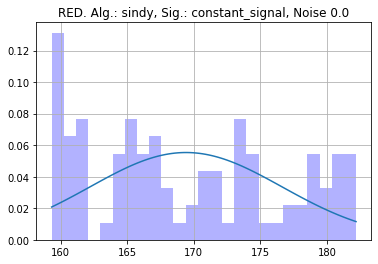

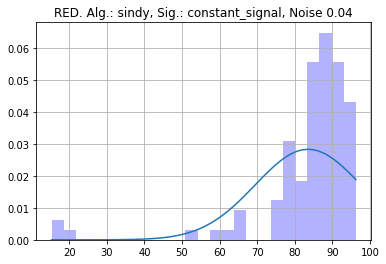

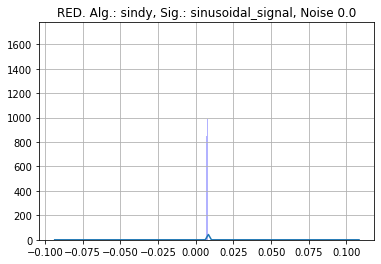

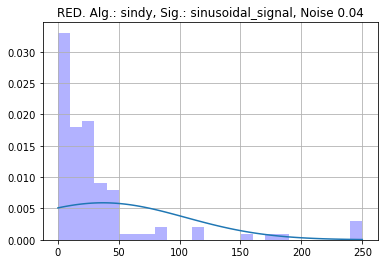

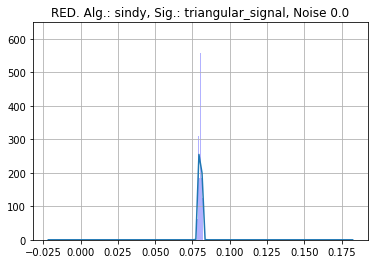

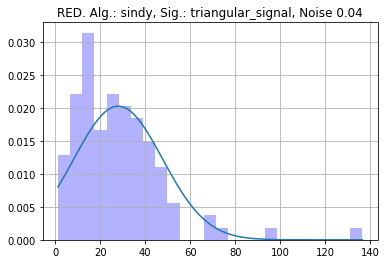

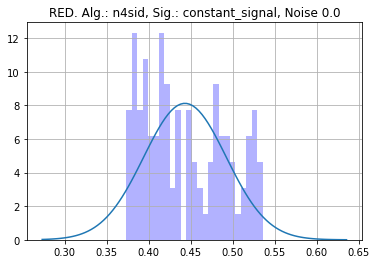

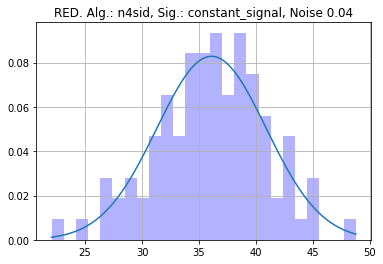

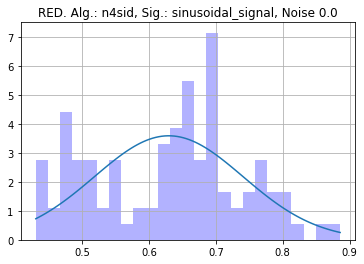

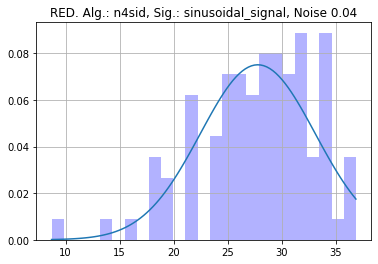

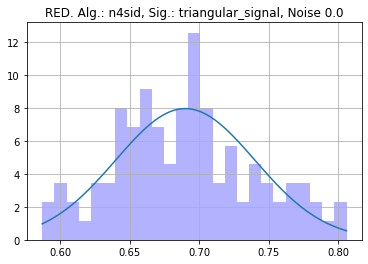

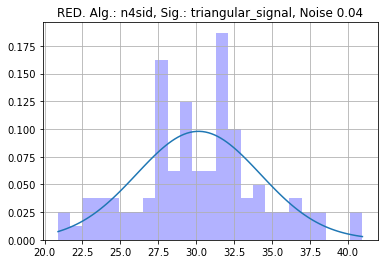

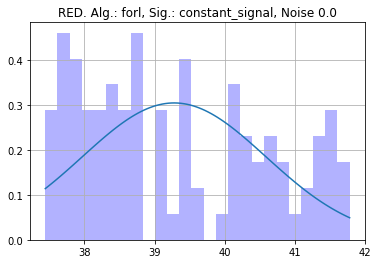

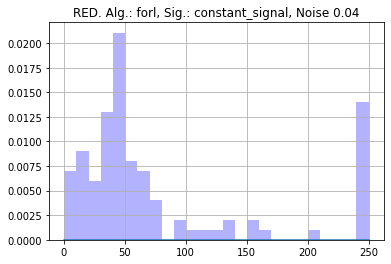

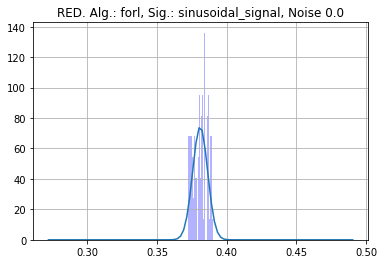

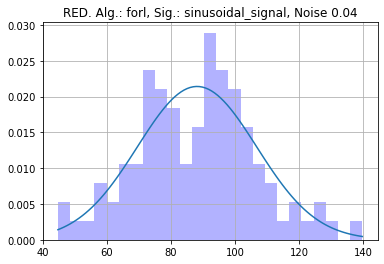

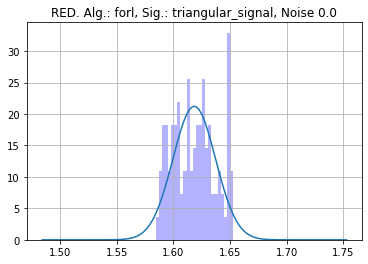

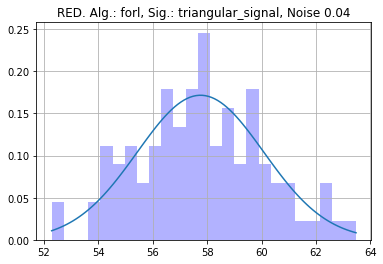

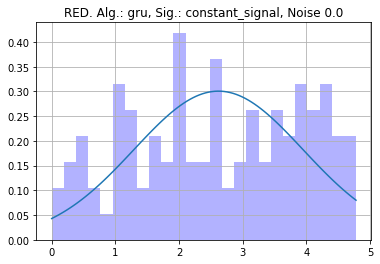

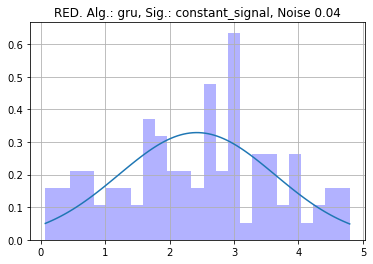

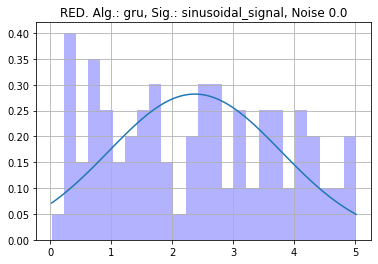

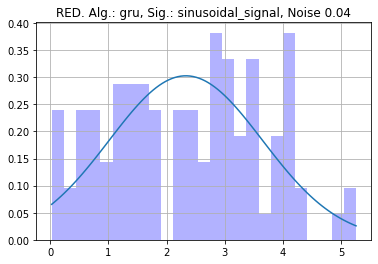

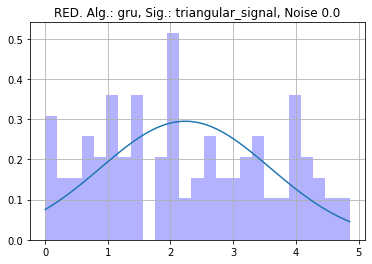

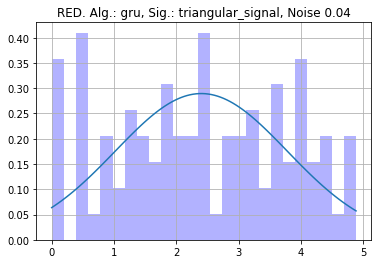

<Figure size 432x288 with 0 Axes>

In [15]:
# Get the accuracy by algorithm, for each type of input signal, with and without noise
analysis_dict = {
    "algorithm": [],
    "signal": [],
    "noise": [],
    "precision": [],
    "rel_error": []
}
dists = {
    "params": [],
    "x": [],
    "y": []
}
for alg_name in alg_dict.keys():
    for sim_i, sim_cond in enumerate(sim_conditions):
        subset_df = res_sig_df.loc[
            (res_sig_df["algorithm"] == alg_name) &
            (res_sig_df["signal"] == sim_cond["sig"].__name__) & 
            (res_sig_df["noise"] == sim_cond["noise"])
        ]
        analysis_dict["algorithm"].append( alg_name )
        analysis_dict["signal"].append( sim_cond["sig"].__name__ )
        analysis_dict["noise"].append( sim_cond["noise"] )
        analysis_dict["rel_error"].append( subset_df["est_acc"].mean() )
        analysis_dict["precision"].append( 
            subset_df["est_acc"].std()
         )
        # Fit distributions for visualization
        # Normal distribution
        dists["params"].append( norm_dist.fit( subset_df["est_acc"] ) )
        if ( np.max(subset_df["est_acc"]) - np.min(subset_df["est_acc"]) > 0.2):
            dists["x"].append( np.linspace(np.min(subset_df["est_acc"]), 
                                           min(np.max(subset_df["est_acc"]), 250), 
                                           100) )
        else:
            dists["x"].append(np.linspace(np.min(subset_df["est_acc"])-0.1, 
                                          np.max(subset_df["est_acc"])+0.1, 
                                          100))
        dists["y"].append( norm_dist.pdf(dists["x"][-1], *dists["params"][-1]) )
        # And plot them
        plt.plot(dists["x"][-1], dists["y"][-1])
        plt.hist(np.clip(subset_df["est_acc"], a_min=0, a_max=250), 
                 bins=25, density=True, alpha=0.3, color='b')
        plt.title( "RED. Alg.: "+alg_name+
                   ", Sig.: {}, Noise {}".format(sim_cond["sig"].__name__, 
                                                 sim_cond["noise"]) )
        plt.grid(True)
        plt.figure()

benchmark_df = pd.DataFrame(analysis_dict)
print(benchmark_df)

# Show
plt.show()